# Mini Proyecto II
**Fundamentos de Análisis y Cálculo Numérico**  

**Integrantes**:  
- Luz Amelia Ibarguen – 2380404  
- Katherine Lopez Unas – 2380339  
- Andres Mauricio Peña Lopez – 2380335

**Profesor**: Ing. Mateo Echeverry Correa  
**Semestre**: 2025-II  

*Predicción de clasificación de imágenes de alimentos Red Neuronal Artificial*

In [16]:
# =============================================================
# ✅ PASO 1: CARGA Y LIMPIEZA DEL DATASET
# =============================================================
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

print("🔹 Paso 1: Cargando y limpiando el dataset...")

# --- Rutas (según tu estructura confirmada) ---
BASE_DIR = "./wonders_dataset"
CSV_PATH = os.path.join(BASE_DIR, "wonders_of_world_images.csv")
IMAGES_ROOT = os.path.join(BASE_DIR, "Wonders of World", "Wonders of World")

# Verificación
assert os.path.isfile(CSV_PATH), f"❌ CSV no encontrado: {CSV_PATH}"
assert os.path.isdir(IMAGES_ROOT), f"❌ Carpeta de imágenes no encontrada: {IMAGES_ROOT}"

# --- Cargar CSV ---
df = pd.read_csv(CSV_PATH)
print(f"✅ CSV cargado: {len(df)} imágenes, {df['folder_name'].nunique()} clases únicas")

# --- Construir rutas absolutas ---
df['image_path'] = df.apply(lambda row: os.path.join(IMAGES_ROOT, row['folder_name'], row['filename']), axis=1)

# --- Verificar y corregir imágenes (¡clave para evitar 6% de accuracy!) ---
print("✅ Convirtiendo imágenes a RGB y eliminando corruptas...")
valid_rows = []
for idx, row in df.iterrows():
    path = row['image_path']
    try:
        with Image.open(path) as img:
            # Forzar conversión a RGB (soluciona modo 'P', 'L', etc.)
            rgb_img = img.convert('RGB')
            rgb_img.save(path, quality=95)  # Sobrescribe en RGB
        valid_rows.append(True)
    except Exception as e:
        print(f"⚠️ Imagen corrupta eliminada: {path} → {e}")
        valid_rows.append(False)

df = df[valid_rows].reset_index(drop=True)
print(f"✅ Dataset limpio: {len(df)} imágenes válidas.")

🔹 Paso 1: Cargando y limpiando el dataset...
✅ CSV cargado: 3846 imágenes, 12 clases únicas
✅ Convirtiendo imágenes a RGB y eliminando corruptas...
✅ Dataset limpio: 3846 imágenes válidas.



🔹 Paso 2: EDA...

📊 Conteo por clase:
folder_name
roman_colosseum          394
machu_pichu              393
great_wall_of_china      392
eiffel_tower             391
burj_khalifa             390
pyramids_of_giza         372
chichen_itza             340
christ_the_reedemer      323
venezuela_angel_falls    251
statue_of_liberty        238
stonehenge               204
taj_mahal                158


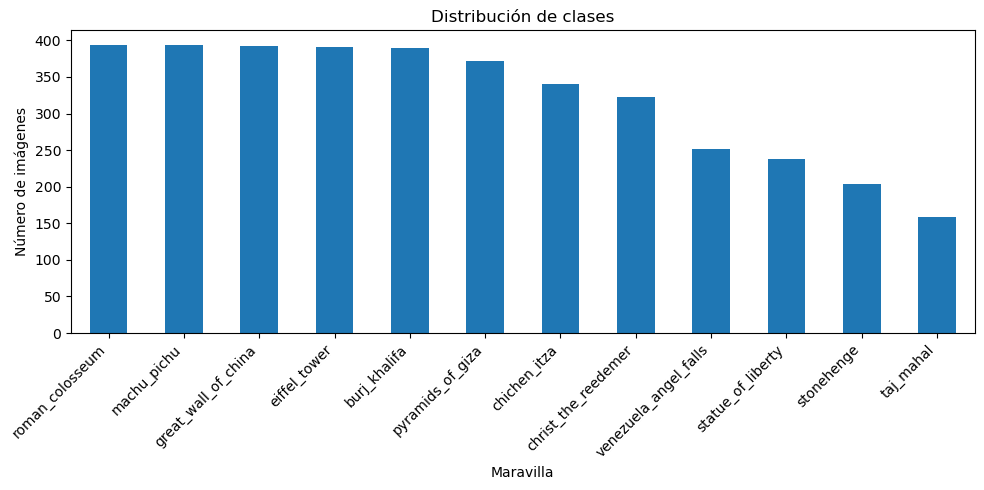


📏 Dimensiones promedio (muestra de 200 imágenes)...
  → Ancho promedio: 580 px
  → Alto promedio:  418 px

🖼️ Muestras aleatorias por clase...


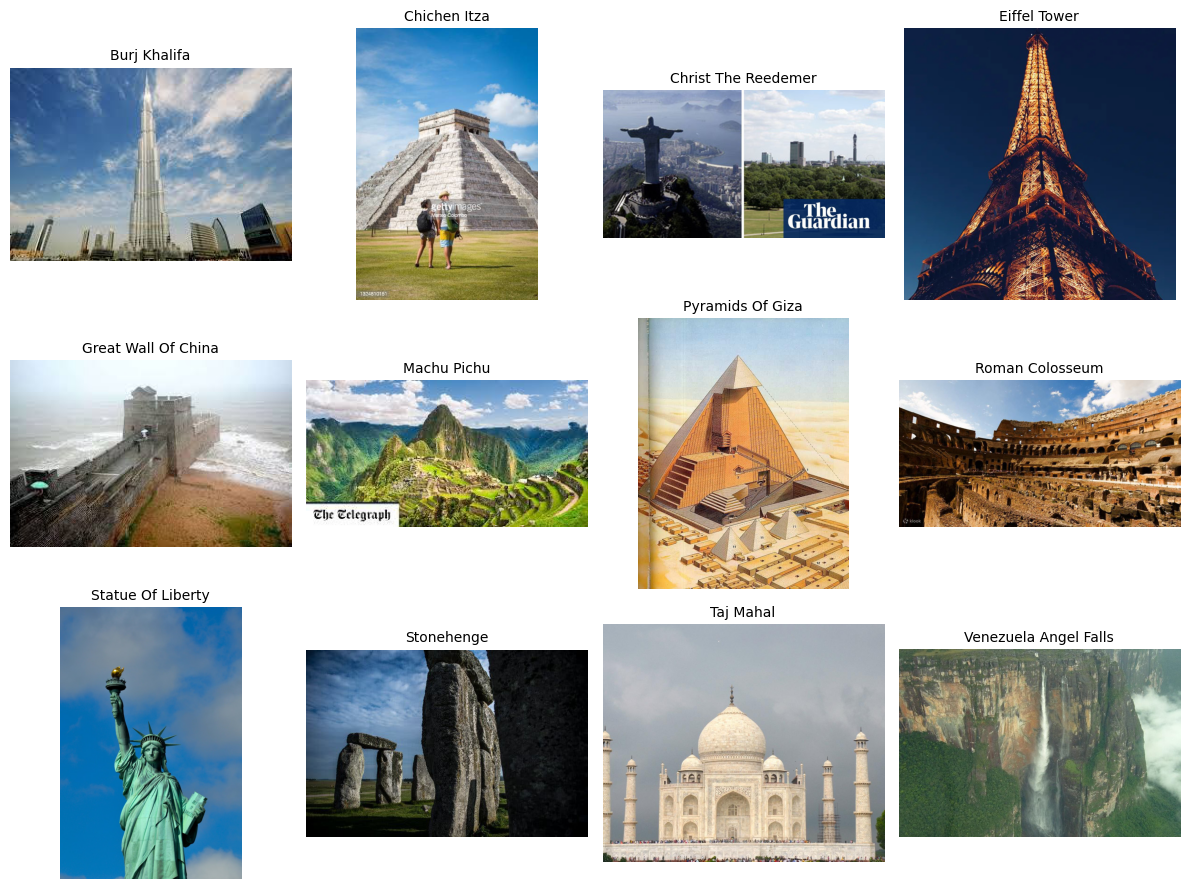

In [17]:
# =============================================================
# ✅ PASO 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# =============================================================
print("\n🔹 Paso 2: EDA...")

# --- Estadísticas descriptivas ---
class_counts = df['folder_name'].value_counts()
print("\n📊 Conteo por clase:")
print(class_counts.to_string())

# Gráfico de distribución
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title("Distribución de clases")
plt.xlabel("Maravilla")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Dimensiones promedio (muestra de 200 imágenes) ---
print("\n📏 Dimensiones promedio (muestra de 200 imágenes)...")
sizes = []
for path in df['image_path'].sample(min(200, len(df)), random_state=42):
    with Image.open(path) as img:
        sizes.append(img.size)
widths, heights = zip(*sizes)
print(f"  → Ancho promedio: {np.mean(widths):.0f} px")
print(f"  → Alto promedio:  {np.mean(heights):.0f} px")

# --- Muestras aleatorias por clase ---
print("\n🖼️ Muestras aleatorias por clase...")
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
class_names = sorted(df['folder_name'].unique())
for i, cls in enumerate(class_names):
    ax = axes[i//4, i%4]
    sample_img = df[df['folder_name'] == cls]['image_path'].sample(1).iloc[0]
    img = Image.open(sample_img)
    ax.imshow(img)
    ax.set_title(cls.replace('_', ' ').title(), fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# =============================================================
# ✅ PASO 3: DATA AUGMENTATION Y CARGA OPTIMIZADA (CPU)
# =============================================================
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

print("\n🔹 Paso 3: Preparando datasets con data augmentation...")

# --- Codificar etiquetas ---
class_names = sorted(df['folder_name'].unique())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
df['label'] = df['folder_name'].map(class_to_idx)

# --- Dividir train/val (80/20, estratificado) ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# --- Función de carga + augmentación ligera ---
def load_and_preprocess(path, label, augment=False):
    image = tf.io.read_file(path)
    # Intenta decode_jpeg primero (más rápido), luego png si falla
    try:
        image = tf.io.decode_jpeg(image, channels=3)
    except tf.errors.InvalidArgumentError:
        image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image = tf.cast(image, tf.float32) / 255.0
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.8, 1.2)
    
    image.set_shape([96, 96, 3])
    return image, to_categorical(label, num_classes=len(class_names))

# --- Crear tf.data ---
BATCH_SIZE = 64  # Ideal para CPU con 12 clases

train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
train_ds = train_ds.map(lambda x, y: load_and_preprocess(x, y, augment=True), 
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(f"✅ Datasets listos: {len(train_df)} train / {len(val_df)} val imágenes.")


🔹 Paso 3: Preparando datasets con data augmentation...
✅ Datasets listos: 3076 train / 770 val imágenes.


In [20]:
# =============================================================
# ✅ PASO 4: ARQUITECTURA CNN (justificada según PDF)
# =============================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

print("\n🔹 Paso 4: Construyendo modelo CNN...")

model = Sequential([
    # Capa 1: 32 filtros 3x3 → reduce ruido, captura bordes simples
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3), padding='same'),
    MaxPooling2D(2,2),
    
    # Capa 2: 64 filtros → patrones más complejos (texturas, formas)
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    # Capa 3: 128 filtros → características semánticas (partes de edificios)
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    # Clasificación
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Evita sobreajuste (crítico en CPU con pocos datos)
    Dense(len(class_names), activation='softmax')  # 12 clases → softmax
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


🔹 Paso 4: Construyendo modelo CNN...


C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454,220 (9.36 MB)

 Trainable params: 2,454,220 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# =============================================================
# ✅ PASO 5: ENTRENAMIENTO (con EarlyStopping y ReduceLROnPlateau)
# =============================================================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('mejor_modelo_wonders.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1281 - loss: 2.4469

49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.1817 - loss: 2.3464 - val_accuracy: 0.3688 - val_loss: 2.0221 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3043 - loss: 2.0791

49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3173 - loss: 2.0420 - val_accuracy: 0.4468 - val_loss: 1.6745 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3999 - loss: 1.7700

49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4217 - loss: 1.7241 - val_accuracy: 0.5234 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4845 - loss: 1.5826

49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4811 - loss: 1.5836 - val_accuracy: 0.5494 - val_loss: 1.3635 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5125 - loss: 1.4284

49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5237 - loss: 1.4308 - val_accuracy: 0.5987 - val_loss: 1.2304 - learning_rate: 0.0010
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.5819 - loss: 1.2824

49/49 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5819 - loss: 1.2739 - val_accuracy: 0.6260 - val_loss: 1.1279 - learning_rate: 0.0010
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5936 - loss: 1.1991

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 712ms/step - accuracy: 0.5998 - loss: 1.1827 - val_accuracy: 0.6416 - val_loss: 1.0716 - learning_rate: 0.0010
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.6603 - loss: 1.0165

49/49 ━━━━━━━━━━━━━━━━━━━━ 47s 829ms/step - accuracy: 0.6596 - loss: 1.0318 - val_accuracy: 0.6519 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.6926 - loss: 0.8902

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 862ms/step - accuracy: 0.6912 - loss: 0.9008 - val_accuracy: 0.7117 - val_loss: 0.9174 - learning_rate: 0.0010
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7399 - loss: 0.7744

49/49 ━━━━━━━━━━━━━━━━━━━━ 72s 659ms/step - accuracy: 0.7373 - loss: 0.7814 - val_accuracy: 0.7286 - val_loss: 0.8930 - learning_rate: 0.0010
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7676 - loss: 0.7095

49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 640ms/step - accuracy: 0.7627 - loss: 0.6960 - val_accuracy: 0.7299 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 860ms/step - accuracy: 0.7871 - loss: 0.6089 - val_accuracy: 0.7234 - val_loss: 0.8926 - learning_rate: 0.0010
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.8105 - loss: 0.5521

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 860ms/step - accuracy: 0.8114 - loss: 0.5313 - val_accuracy: 0.7571 - val_loss: 0.8402 - learning_rate: 0.0010
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.8361 - loss: 0.4709

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - accuracy: 0.8394 - loss: 0.4642 - val_accuracy: 0.7597 - val_loss: 0.8802 - learning_rate: 0.0010
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.8706 - loss: 0.3765

49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 905ms/step - accuracy: 0.8657 - loss: 0.3829 - val_accuracy: 0.7753 - val_loss: 0.8761 - learning_rate: 0.0010
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 794ms/step - accuracy: 0.8761 - loss: 0.3425 - val_accuracy: 0.7636 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 842ms/step - accuracy: 0.8833 - loss: 0.3473 - val_accuracy: 0.7688 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.8848 - loss: 0.3223

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 867ms/step - accuracy: 0.8908 - loss: 0.3239 - val_accuracy: 0.7805 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 693ms/step - accuracy: 0.9044 - loss: 0.2822 - val_accuracy: 0.7766 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 870ms/step - accuracy: 0.9112 - loss: 0.2589 - val_accuracy: 0.7753 - val_loss: 1.0098 - learning_rate: 0.0010
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.9158 - loss: 0.2488

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - accuracy: 0.9256 - loss: 0.2140 - val_accuracy: 0.7935 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 825ms/step - accuracy: 0.9243 - loss: 0.2174 - val_accuracy: 0.7714 - val_loss: 1.0284 - learning_rate: 0.0010
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 834ms/step - accuracy: 0.9340 - loss: 0.1945 - val_accuracy: 0.7844 - val_loss: 0.9735 - learning_rate: 0.0010
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 862ms/step - accuracy: 0.9334 - loss: 0.1982 - val_accuracy: 0.7779 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 758ms/step - accuracy: 0.9464 - loss: 0.1500 - val_accuracy: 0.7909 - val_loss: 0.9529 - learning_rate: 5.0000e-04
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 836ms/step - accuracy: 0.9522 - loss: 0.1288 - val_accuracy: 0.7896 - val_loss: 1.0631 - learning_rate: 5.0000e-04
Epoch 26: early stopping
Restoring model weights from the end of the best epoch:

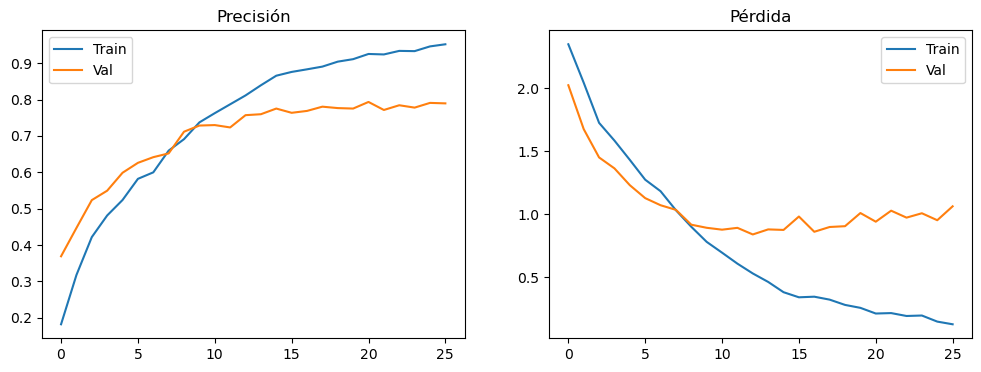

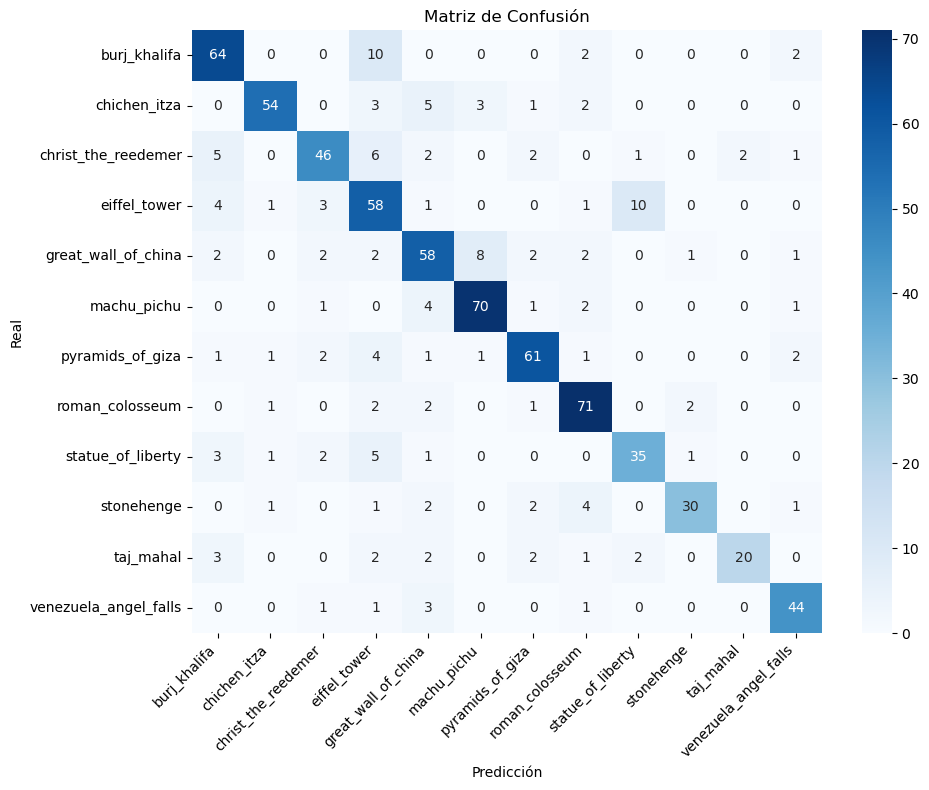


📊 Reporte de Clasificación:
                       precision    recall  f1-score   support

         burj_khalifa       0.78      0.82      0.80        78
         chichen_itza       0.92      0.79      0.85        68
  christ_the_reedemer       0.81      0.71      0.75        65
         eiffel_tower       0.62      0.74      0.67        78
  great_wall_of_china       0.72      0.74      0.73        78
          machu_pichu       0.85      0.89      0.87        79
     pyramids_of_giza       0.85      0.82      0.84        74
      roman_colosseum       0.82      0.90      0.86        79
    statue_of_liberty       0.73      0.73      0.73        48
           stonehenge       0.88      0.73      0.80        41
            taj_mahal       0.91      0.62      0.74        32
venezuela_angel_falls       0.85      0.88      0.86        50

             accuracy                           0.79       770
            macro avg       0.81      0.78      0.79       770
         weighted avg   

C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


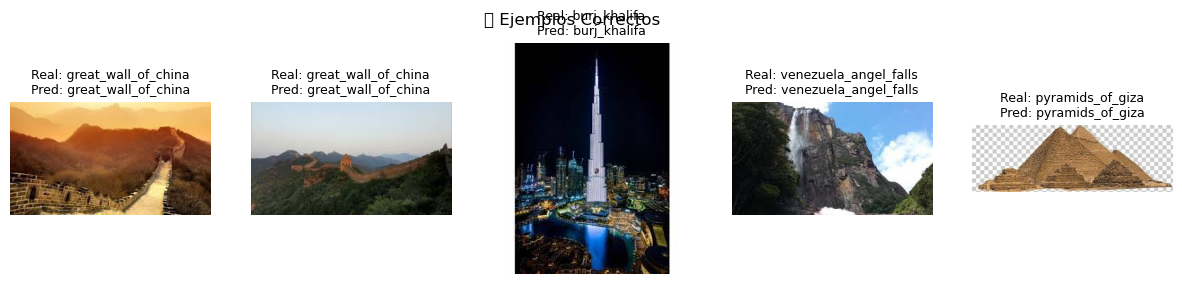

C:\Users\CYS\anaconda3\envs\RN\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


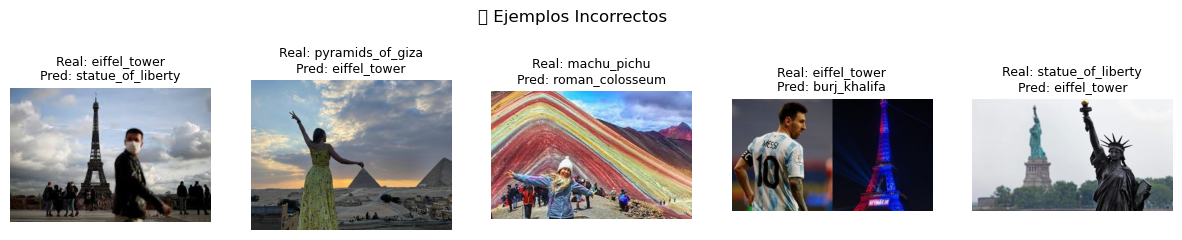

In [23]:
# =============================================================
# ✅ PASO 6: RESULTADOS (gráficas, matriz, ejemplos bien/mal clasificados)
# =============================================================
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Curvas de aprendizaje ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida')
plt.legend()
plt.show()

# --- Matriz de confusión ---
val_predictions = model.predict(val_ds, verbose=0)
y_pred = np.argmax(val_predictions, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Reporte de clasificación ---
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# --- Ejemplos bien/mal clasificados ---
val_paths = val_df['image_path'].values
indices = np.arange(len(val_paths))

correct_idx = indices[y_true == y_pred][:5]
incorrect_idx = indices[y_true != y_pred][:5]

def plot_examples(indices, title):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        path = val_paths[idx]
        img = Image.open(path)
        pred = class_names[y_pred[idx]]
        real = class_names[y_true[idx]]
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img)
        plt.title(f"Real: {real}\nPred: {pred}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_examples(correct_idx, "✅ Ejemplos Correctos")
plot_examples(incorrect_idx, "❌ Ejemplos Incorrectos")